# Pre-processing script with additional stuff

In [20]:
# Profiling
import time  

# Data handling
import pandas as pd
import numpy as np
import geopandas as gpd

pd.set_option('display.max_columns', None)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plotly_colors = px.colors.qualitative.Plotly
sns_palette = sns.color_palette(plotly_colors)
# sns.set_style("whitegrid")  # Uncomment if needed

# Machine Learning & Preprocessing
import pycaret
# from pycaret.clustering import *   # Ambos PyCaret 
# from pycaret.classification import *

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder, PowerTransformer
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import (
    davies_bouldin_score, silhouette_samples, silhouette_score, pairwise_distances
)
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE

# Statistical Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from scipy.stats import kurtosis

In [ ]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

In [23]:
%%time

def lee_shp(filepath):
    """Reads a shapefile and returns a GeoDataFrame."""
    return gpd.read_file(filepath)

# Example usage
gdf = lee_shp('./hex_originalvars_5km.shp')
print(gdf.shape)

(44593, 21)
CPU times: total: 18 s
Wall time: 18.8 s


In [24]:
PLOT = False
if PLOT:
    columna = "burned"
    gdf.plot(aspect="equal", column = columna, figsize=(6, 3), legend=True, cmap='OrRd')
    plt.show()

In [25]:
dfo = pd.DataFrame(gdf)

In [26]:
print("columnas dfo:\n",list(dfo.columns))

columnas dfo:
 ['grid_id', 'burned', 'bio16', 'iucn', 'clay', 'dstrvrs', 'slope', 'wind', 'timtrvl', 'pop', 'fild_sz', 'cattle', 'plntsrc', 'indi', 'propPA', 'forest', 'pasture', 'prodctv', 'noveg', 'Shnnn_D', 'geometry']


In [27]:
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44593 entries, 0 to 44592
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   grid_id   44593 non-null  int64   
 1   burned    44593 non-null  float64 
 2   bio16     44593 non-null  float64 
 3   iucn      44593 non-null  float64 
 4   clay      44593 non-null  float64 
 5   dstrvrs   44593 non-null  float64 
 6   slope     44593 non-null  float64 
 7   wind      44593 non-null  float64 
 8   timtrvl   44593 non-null  float64 
 9   pop       44593 non-null  float64 
 10  fild_sz   44593 non-null  float64 
 11  cattle    44593 non-null  float64 
 12  plntsrc   44593 non-null  float64 
 13  indi      44593 non-null  float64 
 14  propPA    44593 non-null  float64 
 15  forest    44593 non-null  float64 
 16  pasture   44593 non-null  float64 
 17  prodctv   44593 non-null  float64 
 18  noveg     44593 non-null  float64 
 19  Shnnn_D   44593 non-null  float64 
 20  geomet

Eliminates disposable columns if necessary

In [28]:
# Create “complementary” df (for later re-linking)
df_compl = dfo[["grid_id", "geometry"]]

In [29]:
print(list(dfo.columns))

['grid_id', 'burned', 'bio16', 'iucn', 'clay', 'dstrvrs', 'slope', 'wind', 'timtrvl', 'pop', 'fild_sz', 'cattle', 'plntsrc', 'indi', 'propPA', 'forest', 'pasture', 'prodctv', 'noveg', 'Shnnn_D', 'geometry']


## NaN treatment

In [30]:
nan_columns = dfo.columns[dfo.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)

Columns with NaN values: []


## Lista de caracteristicas (features) iniciales a usar en el Analisis

In [31]:
dfo.rename(columns={"dstrvrs": "Distance to rivers"}, errors="raise", inplace=True);
dfo.rename(columns={"timtrvl": "Cities travel time"}, errors="raise", inplace=True);
dfo.rename(columns={"fild_sz": "Field size"}, errors="raise", inplace=True);
dfo.rename(columns={"plntsrc": "Plant richness"}, errors="raise", inplace=True);
dfo.rename(columns={"pasture": "Pasture"}, errors="raise", inplace=True);
dfo.rename(columns={"Shnnn_D": "Cover diversity"}, errors="raise", inplace=True);
dfo.rename(columns={"prodctv": "Productive use"}, errors="raise", inplace=True);
dfo.rename(columns={"noveg": "No vegetation"}, errors="raise", inplace=True);
dfo.rename(columns={"forest": "Forest"}, errors="raise", inplace=True);
dfo.rename(columns={"indi": "Ind. communities"}, errors="raise", inplace=True);
dfo.rename(columns={"slope": "Slope"}, errors="raise", inplace=True);
dfo.rename(columns={"wind": "Wind speed"}, errors="raise", inplace=True);
dfo.rename(columns={"burned": "Burned areas"}, errors="raise", inplace=True);
dfo.rename(columns={"bio16": "BIO16"}, errors="raise", inplace=True);
dfo.rename(columns={"iucn": "IUCN"}, errors="raise", inplace=True);
dfo.rename(columns={"clay": "Soil clay content"}, errors="raise", inplace=True);
dfo.rename(columns={"propPA": "Protected areas"}, errors="raise", inplace=True);
dfo.rename(columns={"cattle": "Cattle"}, errors="raise", inplace=True);
dfo.rename(columns={"pop": "Population"}, errors="raise", inplace=True);

In [32]:
dfo.columns

Index(['grid_id', 'Burned areas', 'BIO16', 'IUCN', 'Soil clay content',
       'Distance to rivers', 'Slope', 'Wind speed', 'Cities travel time',
       'Population', 'Field size', 'Cattle', 'Plant richness',
       'Ind. communities', 'Protected areas', 'Forest', 'Pasture',
       'Productive use', 'No vegetation', 'Cover diversity', 'geometry'],
      dtype='object')

In [33]:
df2use = dfo[['Burned areas','BIO16',
       'IUCN', 'Soil clay content', 
       'Distance to rivers', 'Slope', 'Wind speed', 'Cities travel time',
       'Population', 'Field size', 'Cattle', 'Plant richness',
       'Ind. communities', 'Protected areas', 'Forest', 'Pasture',
       'Productive use', 'No vegetation', 'Cover diversity']]

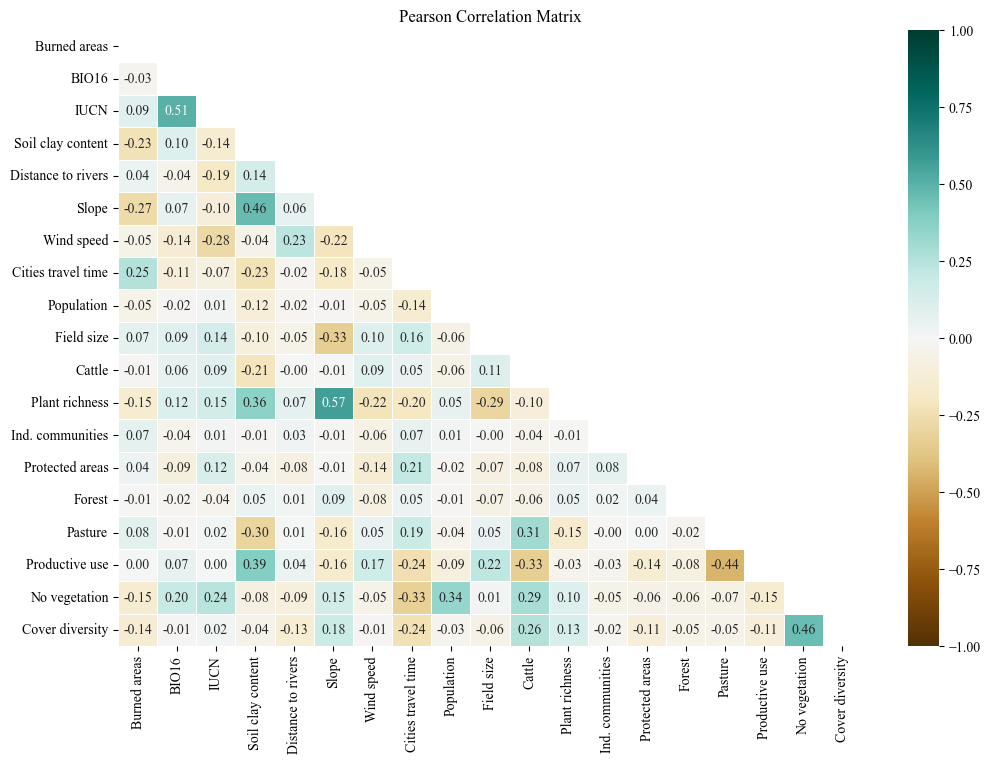

In [34]:
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Calculate the Pearson correlation matrix
correlation_matrix = df2use.corr(method='pearson')

# Create a mask to display only the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='BrBG', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Pearson Correlation Matrix')
plt.show()

### Negative variables?

In [35]:
if dfo.any().min() < 0:
    for col in features:
        if dfo[col].min() < 0:
            print(col,"There are negative values")
    
            GRAFICA = True
            if GRAFICA:
                print(col+":")
                sns.set_theme(rc={'figure.figsize':(18,1)})
                sns.boxplot(x=df[col]);
                print("std:",df[col].std(), "min:",df[col].min(), "max:",df[col].max(),"mean:",df[col].mean()) 
                plt.show()
                sns.set_theme(rc={'figure.figsize':(18,2)})
                plt.plot(df[col],alpha=0.6);
                plt.show()
else:
    print("There are no negative values")

There are no negative values


### General vision of the data to use

In [36]:
print(dfo.head(5))

   grid_id  Burned areas        BIO16        IUCN  Soil clay content  \
0        1      4.204782  4913.908203  595.000000         134.133453   
1        2      1.457886  4915.803223  625.000000         180.316101   
2        3     17.803116  4847.290039  595.000000         186.862198   
3        4     40.731319  4934.294922  618.788818         179.217239   
4        5      0.523696  4857.871094  625.000000          66.832718   

   Distance to rivers     Slope  Wind speed  Cities travel time  Population  \
0          310.438538  0.736595    3.214067          212.106445    0.000000   
1          348.079987  0.090427    3.103770          192.372375    0.070389   
2          278.723572  0.086626    3.333107          194.655563    0.000000   
3          338.313232  0.788421    3.203120          168.691422    1.624188   
4          346.576538  0.244312    4.543200          144.070007    0.000000   

   Field size       Cattle  Plant richness  Ind. communities  Protected areas  \
0         0

In [37]:
print(dfo.describe(include='all'))

             grid_id  Burned areas         BIO16          IUCN  \
count   44593.000000  44593.000000  44593.000000  44593.000000   
unique           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN   
mean    22354.836723      2.441769   5993.033993    673.234083   
std     12893.638339      5.781409    937.422639     83.156220   
min         1.000000      0.000000   3615.373047    409.000000   
25%     11192.000000      0.000000   5354.718750    638.000000   
50%     22350.000000      0.000000   5859.161133    697.988708   
75%     33523.000000      1.857562   6549.202148    725.951355   
max     44691.000000     69.293205  10007.715820    863.000000   

        Soil clay content  Distance to rivers         Slope    Wind speed  \
count        44593.000000        44593.000000  44593.000000  44593.000000   
unique                NaN                 NaN        

In [38]:
print(df2use.kurt())

Burned areas           20.494590
BIO16                   0.257508
IUCN                    0.595094
Soil clay content      -0.317428
Distance to rivers      1.074030
Slope                   4.394530
Wind speed              0.310304
Cities travel time      4.946200
Population            333.722838
Field size             -1.667443
Cattle                 11.258714
Plant richness         -0.460510
Ind. communities      191.157216
Protected areas        16.767159
Forest                  0.000000
Pasture                 0.000000
Productive use          0.000000
No vegetation           0.000000
Cover diversity         0.372361
dtype: float64


#### Kurtosis > 3 → Leptokurtic (Heavy tails, more outliers)
#### Kurtosis = 3 → Mesokurtic (Normal distribution)
#### Kurtosis < 3 → Platykurtic (Light tails, fewer outliers)

In [39]:
zero_threshold = 0.5  # Adjust this threshold as needed (e.g., 0.5 for 50%)
zero_counts = (dfo == 0).sum()  # Count zeros in each column
zero_percentage = zero_counts / len(dfo)  # Calculate zero proportion

high_zero_columns = zero_percentage[zero_percentage > zero_threshold].index.tolist()

print("Columns with high zero concentrations:", high_zero_columns)

Columns with high zero concentrations: ['Burned areas', 'Ind. communities', 'Protected areas']


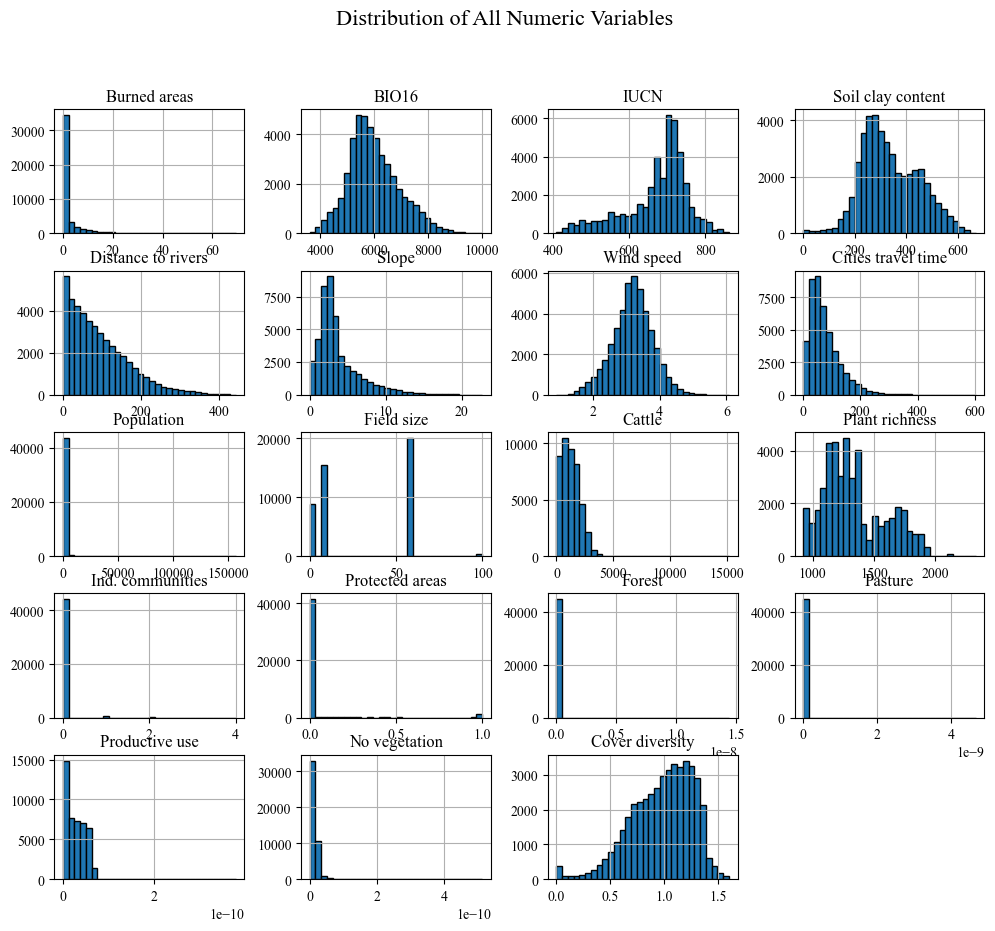

In [40]:
df2use.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Distribution of All Numeric Variables", fontsize=16)
plt.show()

In [41]:
df2use = [col for col in df2use if col in dfo.columns and dfo[col].dtype in ['int64', 'float64']]

In [42]:
# StandardScaler Initialization
scaler = StandardScaler()
dfo_scaled = dfo.copy()  # Keep a copy of the original data

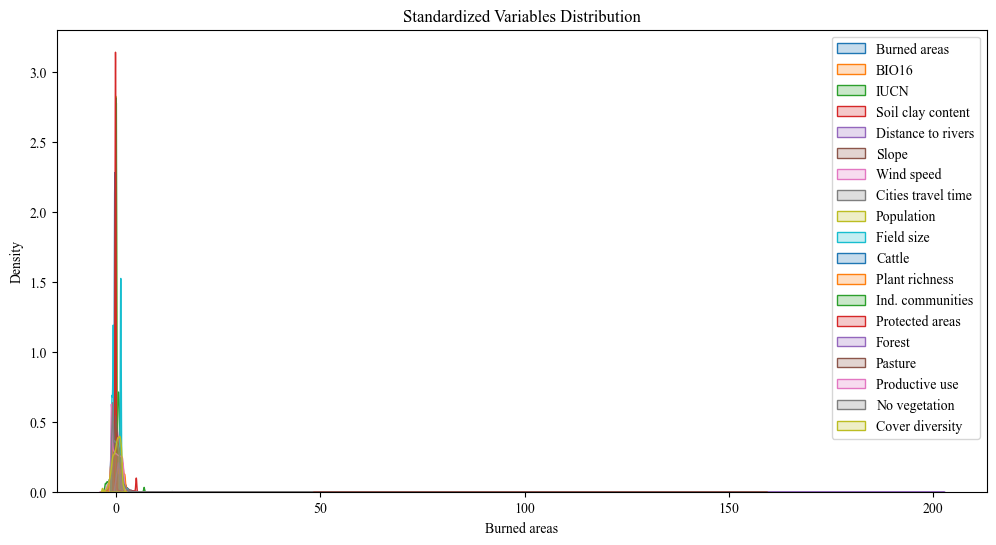

In [43]:
# ✅ Properly check if df2use has valid columns before scaling
if len(df2use) > 0:  # Correct way to check if df2use is not empty
    dfo_scaled[df2use] = scaler.fit_transform(dfo[df2use])

    # Plot the distributions of the scaled variables
    plt.figure(figsize=(12, 6))
    for col in df2use:
        sns.kdeplot(dfo_scaled[col], label=col, fill=True)

    plt.title("Standardized Variables Distribution")
    plt.legend()
    plt.show()
else:
    print("⚠️ No valid numeric columns found in df2use!")

In [44]:
print("columnas dfo_scaled:\n",list(dfo_scaled.columns))

columnas dfo_scaled:
 ['grid_id', 'Burned areas', 'BIO16', 'IUCN', 'Soil clay content', 'Distance to rivers', 'Slope', 'Wind speed', 'Cities travel time', 'Population', 'Field size', 'Cattle', 'Plant richness', 'Ind. communities', 'Protected areas', 'Forest', 'Pasture', 'Productive use', 'No vegetation', 'Cover diversity', 'geometry']


In [45]:
dfo_scaled[df2use].head(2)

,Burned areas,BIO16,IUCN,Soil clay content,Distance to rivers,Slope,Wind speed,Cities travel time,Population,Field size,Cattle,Plant richness,Ind. communities,Protected areas,Forest,Pasture,Productive use,No vegetation,Cover diversity
0,0.304949,-1.151175,-0.940819,-1.820476,2.882345,-1.029724,0.045957,2.490790,-0.158146,-1.138211,-1.311915,-0.485623,-0.102125,4.845783,-0.091461,0.863291,-1.29472,-1.083945,-0.214704
1,-0.170182,-1.149154,-0.580048,-1.405487,3.380807,-1.250476,-0.138097,2.132678,-0.158127,-1.138211,-1.480922,-0.485623,-0.102125,4.845783,-0.215387,2.094366,-1.29472,-1.083945,-3.447077


In [46]:
dfo[df2use].head(2)

,Burned areas,BIO16,IUCN,Soil clay content,Distance to rivers,Slope,Wind speed,Cities travel time,Population,Field size,Cattle,Plant richness,Ind. communities,Protected areas,Forest,Pasture,Productive use,No vegetation,Cover diversity
0,4.204782,4913.908203,595.0,134.133453,310.438538,0.736595,3.214067,212.106445,0.000000,0.0,186.508865,1216.0,0.0,1.0,8.823000e-12,4.534300e-11,0.0,0.0,0.918072
1,1.457886,4915.803223,625.0,180.316101,348.079987,0.090427,3.103770,192.372375,0.070389,0.0,48.792526,1216.0,0.0,1.0,0.000000e+00,8.134800e-11,0.0,0.0,0.000000


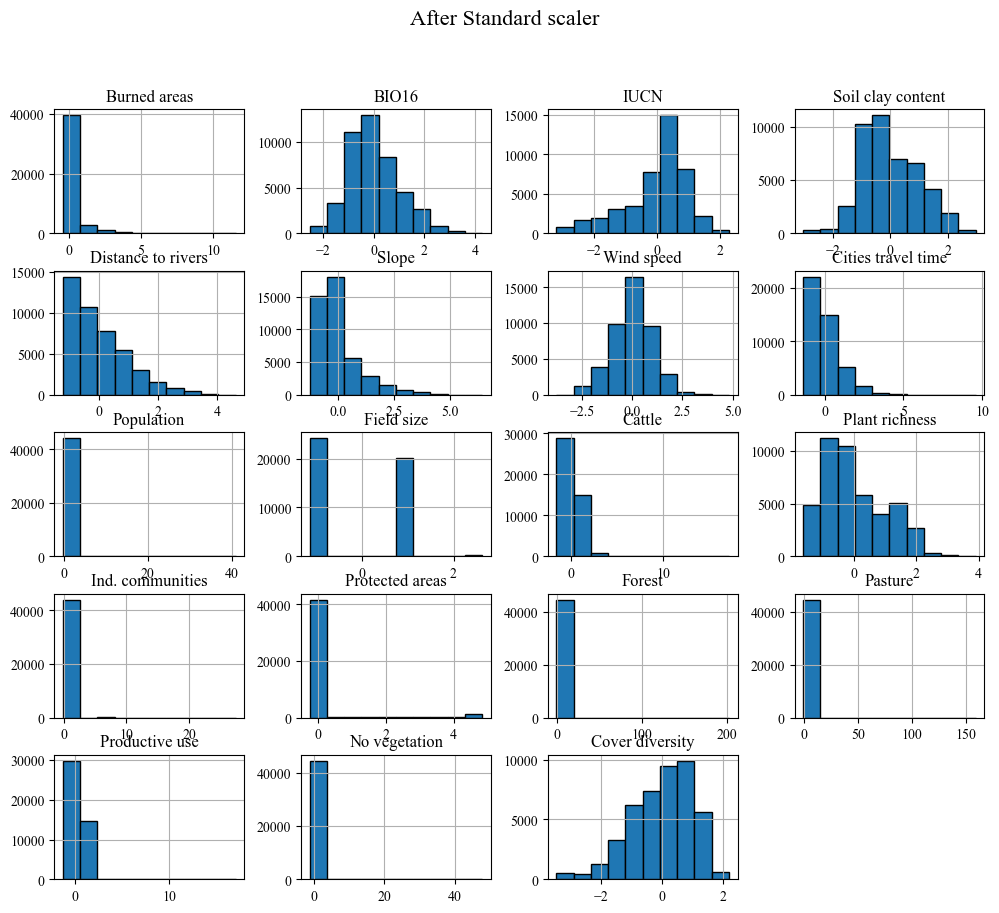

In [47]:
dfo_scaled[df2use].hist(figsize=(12, 10), edgecolor='black')
plt.suptitle("After Standard scaler", fontsize=16)
plt.show()

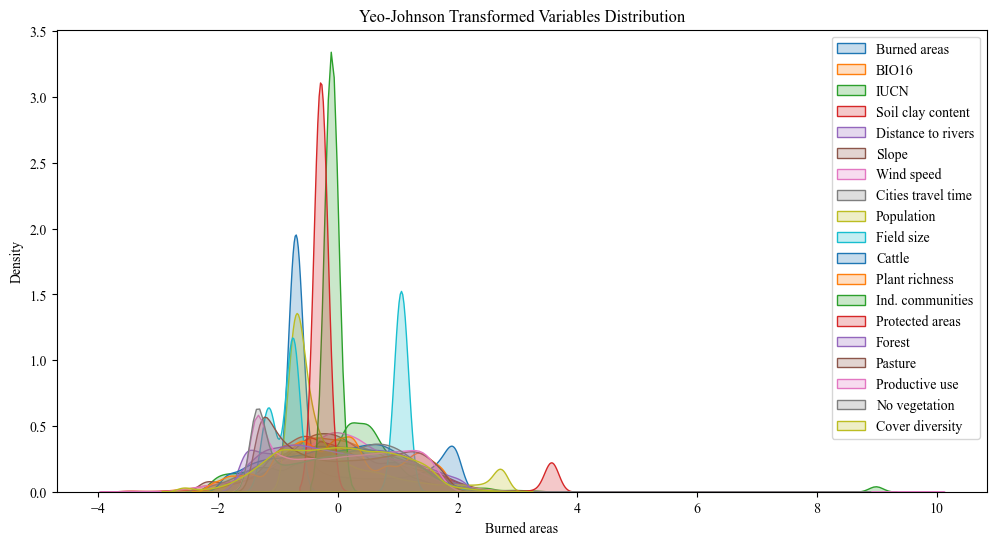

In [48]:
# Ensure df2use contains valid numeric column names
df2use = [col for col in df2use if col in dfo_scaled.columns and dfo_scaled[col].dtype in ['int64', 'float64']]

# Initialize PowerTransformer with Yeo-Johnson method
pt = PowerTransformer(method='yeo-johnson')

# Apply transformation only to the selected numeric columns
if len(df2use) > 0:  # Ensure df2use is not empty
    dfo_scaled[df2use] = pt.fit_transform(dfo_scaled[df2use])

    # Plot the distributions of the transformed variables
    plt.figure(figsize=(12, 6))
    for col in df2use:
        sns.kdeplot(dfo_scaled[col], label=col, fill=True)

    plt.title("Yeo-Johnson Transformed Variables Distribution")
    plt.legend()
    plt.show()
else:
    print("⚠️ No valid numeric columns found in df2use!")

In [49]:
#Data after YJ Transformation:
dfo_scaled[df2use].head(5)

,Burned areas,BIO16,IUCN,Soil clay content,Distance to rivers,Slope,Wind speed,Cities travel time,Population,Field size,Cattle,Plant richness,Ind. communities,Protected areas,Forest,Pasture,Productive use,No vegetation,Cover diversity
0,1.502202,-1.241461,-1.033638,-2.023439,2.035779,-1.646283,0.028712,1.870614,-0.782090,-1.207511,-1.558185,-0.381238,-0.111337,3.569372,-0.288041,1.318487,-1.400161,-1.390055,-0.363638
1,0.583166,-1.238819,-0.761558,-1.506594,2.222970,-2.279213,-0.155037,1.727209,-0.781524,-1.207511,-1.820541,-0.381238,-0.111337,3.569372,-1.727220,2.061603,-1.400161,-1.390055,-2.599557
2,1.970845,-1.334835,-1.033638,-1.434839,1.863343,-2.283148,0.228791,1.744529,-0.782090,-1.207511,-0.749129,-0.381238,-0.111337,3.569372,-1.554899,1.884449,-1.400161,-1.390055,-2.180412
3,2.010954,-1.213083,-0.820925,-1.518677,2.176018,-1.598617,0.010402,1.534354,-0.769055,-1.207511,0.134223,-0.381238,-0.111337,3.569371,-0.936466,1.803981,-1.260181,-1.390055,-1.730878
4,-0.151478,-1.319939,-0.761558,-2.806712,2.215812,-2.121974,2.328960,1.302253,-0.782090,-1.207511,-1.878777,-0.381238,-0.111337,3.569372,-1.067332,0.555978,-1.400161,-1.390055,-0.778626


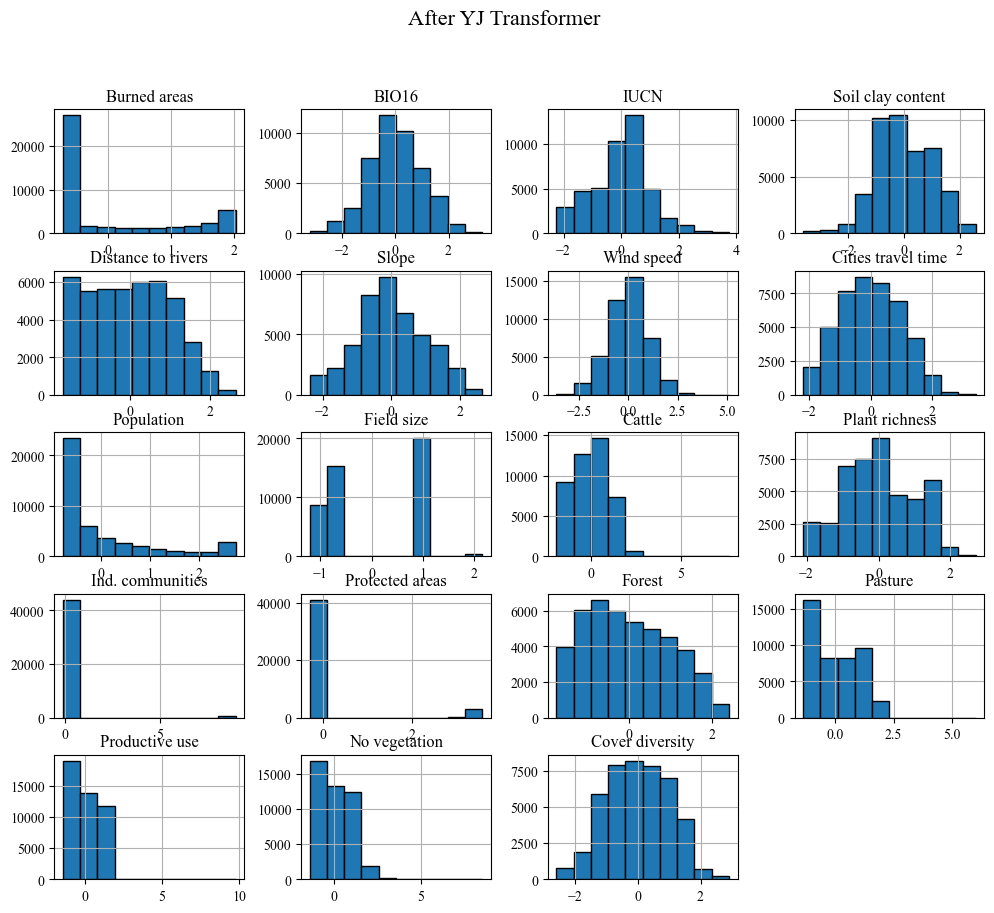

In [50]:
dfo_scaled[df2use].hist(figsize=(12, 10), edgecolor='black')
plt.suptitle("After YJ Transformer", fontsize=16)
plt.show()

Merge Scaled Data Back to Original Table

In [51]:
# Ensure 'grid_id' exists in both DataFrames
if 'grid_id' in dfo.columns and 'grid_id' in dfo_scaled.columns:
    # Select only 'grid_id' and the transformed columns from dfo_scaled
    dfo_scaled_subset = dfo_scaled[['grid_id'] + df2use]

    # Merge the original and transformed data on 'grid_id'
    dfo_final = dfo.merge(dfo_scaled_subset, on='grid_id', suffixes=('', '_new'))

    print("✅ Merged DataFrame Created Successfully!")
    print(dfo_final.head())  # Display first few rows
else:
    print("⚠️ 'grid_id' is missing from one of the DataFrames!")

✅ Merged DataFrame Created Successfully!
   grid_id  Burned areas        BIO16        IUCN  Soil clay content  \
0        1      4.204782  4913.908203  595.000000         134.133453   
1        2      1.457886  4915.803223  625.000000         180.316101   
2        3     17.803116  4847.290039  595.000000         186.862198   
3        4     40.731319  4934.294922  618.788818         179.217239   
4        5      0.523696  4857.871094  625.000000          66.832718   

   Distance to rivers     Slope  Wind speed  Cities travel time  Population  \
0          310.438538  0.736595    3.214067          212.106445    0.000000   
1          348.079987  0.090427    3.103770          192.372375    0.070389   
2          278.723572  0.086626    3.333107          194.655563    0.000000   
3          338.313232  0.788421    3.203120          168.691422    1.624188   
4          346.576538  0.244312    4.543200          144.070007    0.000000   

   Field size       Cattle  Plant richness  Ind. co

In [52]:
dfo_final.columns

Index(['grid_id', 'Burned areas', 'BIO16', 'IUCN', 'Soil clay content',
       'Distance to rivers', 'Slope', 'Wind speed', 'Cities travel time',
       'Population', 'Field size', 'Cattle', 'Plant richness',
       'Ind. communities', 'Protected areas', 'Forest', 'Pasture',
       'Productive use', 'No vegetation', 'Cover diversity', 'geometry',
       'Burned areas_new', 'BIO16_new', 'IUCN_new', 'Soil clay content_new',
       'Distance to rivers_new', 'Slope_new', 'Wind speed_new',
       'Cities travel time_new', 'Population_new', 'Field size_new',
       'Cattle_new', 'Plant richness_new', 'Ind. communities_new',
       'Protected areas_new', 'Forest_new', 'Pasture_new',
       'Productive use_new', 'No vegetation_new', 'Cover diversity_new'],
      dtype='object')

#### K-means section: with new columns

In [53]:
df2use_new = dfo_final[['Burned areas_new', 'BIO16_new', 'IUCN_new', 'Soil clay content_new',
       'Distance to rivers_new', 'Slope_new', 'Wind speed_new',
       'Cities travel time_new', 'Population_new', 'Field size_new',
       'Cattle_new', 'Plant richness_new', 'Ind. communities_new',
       'Protected areas_new', 'Forest_new', 'Pasture_new',
       'Productive use_new', 'No vegetation_new', 'Cover diversity_new']]

### K-means is always aleatory, meaning results are never 100% the same

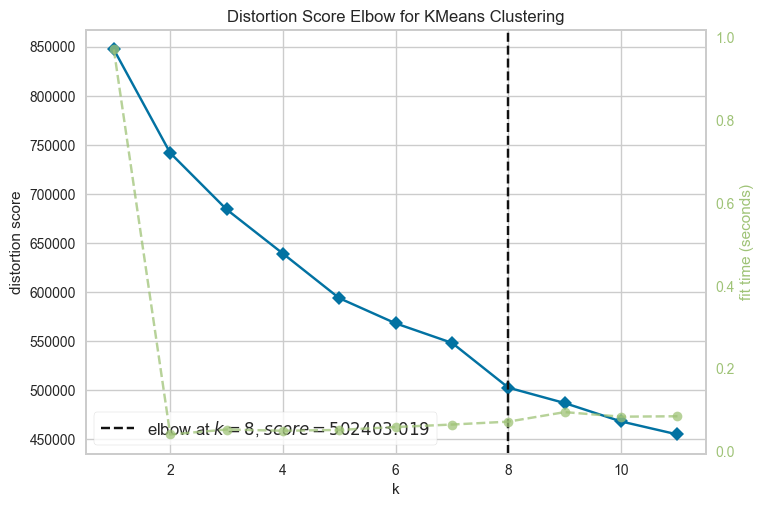

YellowbrickAttributeError: neither visualizer 'KElbowVisualizer' nor wrapped estimator 'KMeans' have attribute 'elbow_value'

In [54]:
X = df2use_new.to_numpy()
X.shape
#from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,12))
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
elbow_value = visualizer.elbow_value

We have tested several numbers of K, and that is why now I am only doing 9 (the selected number)

In [55]:
X = df2use_new
n_clusters = 9
cluster_colname = "kmeans_" + str(n_clusters)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1234, n_init="auto", verbose=0, max_iter=500).fit(X)
y = kmeans.predict(X)
dfo_final[cluster_colname] = y

In [56]:
unique_values = dfo_final["kmeans_9"].unique()
print(unique_values)

[7 5 1 0 2 4 3 8 6]


In [57]:
#Since Python starts from 0, I will add a 1 to all values and avoid having a cluster 0

dfo_final["kmeans_9"] = dfo_final["kmeans_9"] + 1
unique_values = dfo_final["kmeans_9"].unique()
print(unique_values)

[8 6 2 1 3 5 4 9 7]


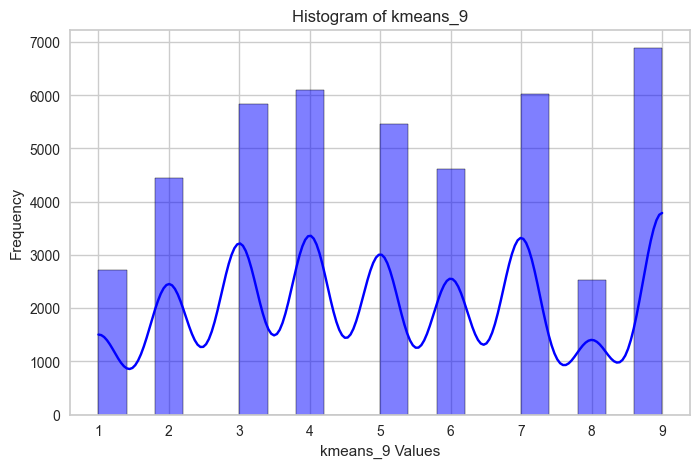

In [58]:
# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(dfo_final["kmeans_9"], bins=20, kde=True, color="blue")
# Labels and title
plt.xlabel("kmeans_9 Values")
plt.ylabel("Frequency")
plt.title("Histogram of kmeans_9")

# Show the plot
plt.show()

### Distances to centroids

In [59]:
# Number of clusters
num_clusters = 9  # Adjust based on your model
num_runs = 100

X = df2use_new
# Store distances for each run
all_distances = np.zeros((X.shape[0], num_runs))

# Run K-Means 100 times and store distances
for i in range(num_runs):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=i)
    kmeans.fit(X)
    distances = kmeans.transform(X)
    all_distances[:, i] = np.min(distances, axis=1)  # Closest centroid distance

# Compute the **average** distance to the assigned centroids across 100 runs
dfo_final["average_distance_to_centroid"] = np.mean(all_distances, axis=1)
# Display the first few rows
#print(dfo_final[["grid_id", "average_distance_to_centroid"]].head())
print(dfo_final.head())

   grid_id  Burned areas        BIO16        IUCN  Soil clay content  \
0        1      4.204782  4913.908203  595.000000         134.133453   
1        2      1.457886  4915.803223  625.000000         180.316101   
2        3     17.803116  4847.290039  595.000000         186.862198   
3        4     40.731319  4934.294922  618.788818         179.217239   
4        5      0.523696  4857.871094  625.000000          66.832718   

   Distance to rivers     Slope  Wind speed  Cities travel time  Population  \
0          310.438538  0.736595    3.214067          212.106445    0.000000   
1          348.079987  0.090427    3.103770          192.372375    0.070389   
2          278.723572  0.086626    3.333107          194.655563    0.000000   
3          338.313232  0.788421    3.203120          168.691422    1.624188   
4          346.576538  0.244312    4.543200          144.070007    0.000000   

   Field size       Cattle  Plant richness  Ind. communities  Protected areas  \
0         0

In [60]:
dfo_final.columns

Index(['grid_id', 'Burned areas', 'BIO16', 'IUCN', 'Soil clay content',
       'Distance to rivers', 'Slope', 'Wind speed', 'Cities travel time',
       'Population', 'Field size', 'Cattle', 'Plant richness',
       'Ind. communities', 'Protected areas', 'Forest', 'Pasture',
       'Productive use', 'No vegetation', 'Cover diversity', 'geometry',
       'Burned areas_new', 'BIO16_new', 'IUCN_new', 'Soil clay content_new',
       'Distance to rivers_new', 'Slope_new', 'Wind speed_new',
       'Cities travel time_new', 'Population_new', 'Field size_new',
       'Cattle_new', 'Plant richness_new', 'Ind. communities_new',
       'Protected areas_new', 'Forest_new', 'Pasture_new',
       'Productive use_new', 'No vegetation_new', 'Cover diversity_new',
       'kmeans_9', 'average_distance_to_centroid'],
      dtype='object')

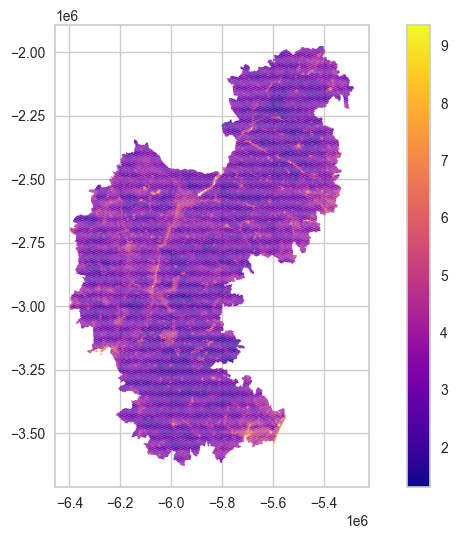

In [61]:
gdf = gpd.GeoDataFrame(dfo_final, geometry="geometry")

# Plot polygons with color based on "average_distance_to_centroid"
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(column="average_distance_to_centroid", 
         cmap="plasma",  # Choose a color map ('coolwarm', 'plasma', etc.)
         legend=True, 
         ax=ax)
plt.show()

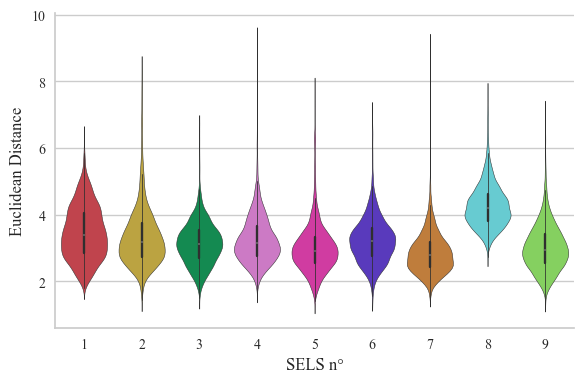

In [62]:
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Define a custom color palette for kmeans_9 values
custom_palette = {
    '1': '#D4303B', 
    '2': '#CFAF2D', 
    '3': '#009E52', 
    '4': '#DA6CD1', 
    '5': '#E923AA', 
    '6': '#4D24D2',
    '7': '#D57D26',
    '8': '#55DBE3',
    '9': '#7FE34D'
}

# Define the desired order for the violin plots
cluster_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a violin plot using seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(x='kmeans_9', y='average_distance_to_centroid', data=dfo_final, palette=custom_palette, order=cluster_order)

# Set plot title and labels
plt.title('', fontsize=12)  # Optional: Add a title and adjust font size
plt.xlabel('SELS n°', fontsize=12)  # Adjust font size for x-label
plt.ylabel('Euclidean Distance', fontsize=12)  # Adjust font size for y-label

# Remove the top and right spines
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()

## Variable Importance Analysis: for all SELS together

In [63]:
selected_cols = dfo_final[['Burned areas_new', 'BIO16_new', 'IUCN_new', 'Soil clay content_new',
       'Distance to rivers_new', 'Slope_new', 'Wind speed_new',
       'Cities travel time_new', 'Population_new', 'Field size_new',
       'Cattle_new', 'Plant richness_new', 'Ind. communities_new',
       'Protected areas_new', 'Forest_new', 'Pasture_new',
       'Productive use_new', 'No vegetation_new', 'Cover diversity_new']]

selected_cols.columns

Index(['Burned areas_new', 'BIO16_new', 'IUCN_new', 'Soil clay content_new',
       'Distance to rivers_new', 'Slope_new', 'Wind speed_new',
       'Cities travel time_new', 'Population_new', 'Field size_new',
       'Cattle_new', 'Plant richness_new', 'Ind. communities_new',
       'Protected areas_new', 'Forest_new', 'Pasture_new',
       'Productive use_new', 'No vegetation_new', 'Cover diversity_new'],
      dtype='object')

In [66]:
# define dataset
X = selected_cols

y = dfo_final['kmeans_9']

In [68]:
# define the model
model = RandomForestRegressor(random_state=0)
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance

                   feature  importance  importance_std
2                 IUCN_new    0.243181        0.002165
11      Plant richness_new    0.206274        0.001935
13     Protected areas_new    0.190349        0.002292
17       No vegetation_new    0.121880        0.001696
5                Slope_new    0.121678        0.001422
8           Population_new    0.120765        0.001616
14              Forest_new    0.105367        0.000971
16      Productive use_new    0.105222        0.000706
18     Cover diversity_new    0.101939        0.001245
3    Soil clay content_new    0.093914        0.000656
0         Burned areas_new    0.090836        0.001443
6           Wind speed_new    0.083069        0.000486
15             Pasture_new    0.070918        0.000823
10              Cattle_new    0.060982        0.000903
1                BIO16_new    0.027132        0.000341
7   Cities travel time_new    0.025099        0.000471
4   Distance to rivers_new    0.013887        0.000240
9         

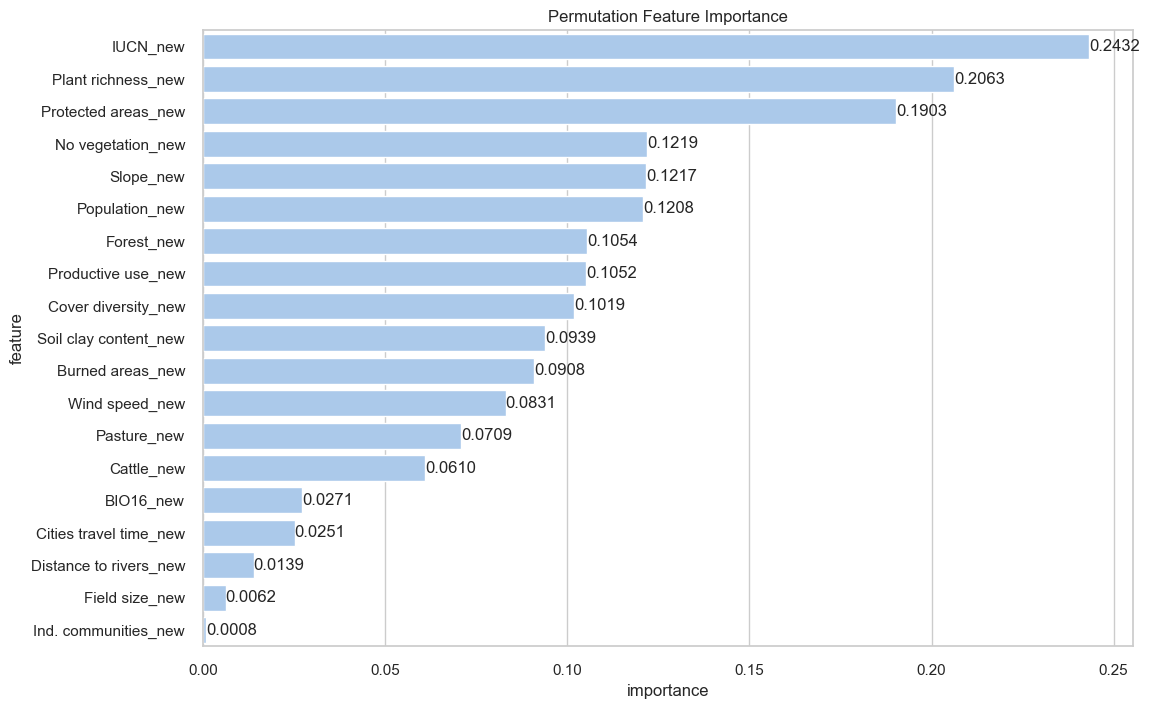

In [69]:
# Compute permutation feature importance
result = permutation_importance(model, X, y, n_repeats=10, random_state=0)

# Create a DataFrame to store feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Display the feature importance
print(importance_df)

# Optional: Plot the permutation feature importance

sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, y="feature", x="importance", orient="h")

# Add score numbers to each bar
for index, value in enumerate(importance_df['importance']):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.title("Permutation Feature Importance")
plt.show()

To run the model by SELS, the SELS column must be converted into binary values (the target SELS = 1, the rest of the SELS = 0).

## t-SNE plots

In [210]:
%%time
m = TSNE(learning_rate=100)
tsne_features = m.fit_transform(df2use_new) 

CPU times: total: 26min 51s
Wall time: 2min 36s


In [211]:
tsne_features.shape

(44593, 2)

In [213]:
df2use_new['x'] = tsne_features[:,0]
df2use_new['y'] = tsne_features[:,1]

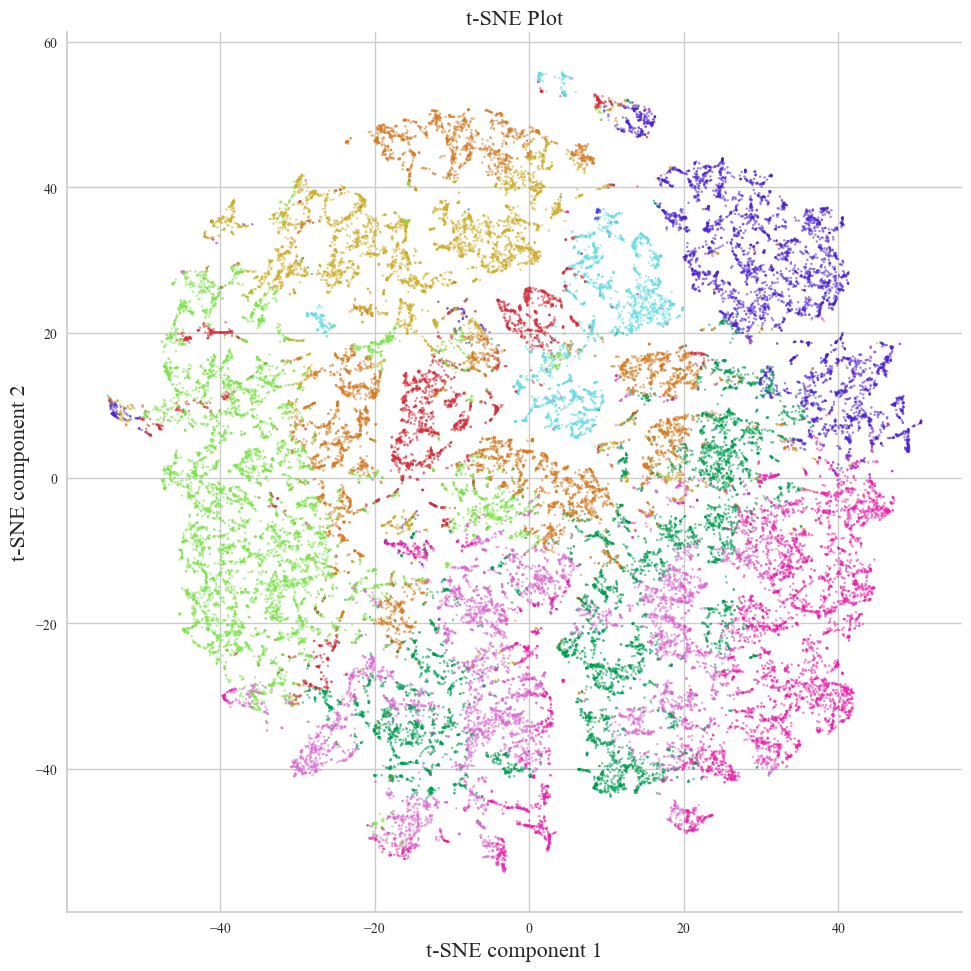

In [214]:
# Define the colors and new names you want to use for each cluster
cluster_colors = {
    1: "#d4303b",
    2: '#cfaf2d',
    3: '#009e52',
    4: '#da6cd1',
    5: '#e923aa',
    6: '#4d24d2',
    7: '#d57d26',
    8: '#6ddde3',
    9: '#7fe34d'
}

# Set font family to Times New Roman and increase font size globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16  # Adjust the font size as needed

# Create a new column in your dataframe for the colors
dfo_final['color'] = dfo_final['kmeans_9'].map(cluster_colors)

plt.figure(figsize=(10, 10))

# Scatter plot of the t-SNE components with manually set colors
scatter = plt.scatter(df2use_new['x'], df2use_new['y'], c=dfo_final['color'], s=2, alpha=0.5)

# Adding labels and title
plt.xlabel('t-SNE component 1', fontsize=16)  # Optional: Adjust font size for x-label
plt.ylabel('t-SNE component 2', fontsize=16)  # Optional: Adjust font size for y-label
plt.title('t-SNE Plot', fontsize=16)  # Optional: Adjust font size for title

# Remove top and right spines
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a legend with renamed clusters (commented out as per your original code)
# handles = [mpatches.Patch(color=color, label=cluster_names[cluster]) for cluster, color in cluster_colors.items()]
# plt.legend(handles=handles, title="Clusters")

# Show plot
plt.tight_layout()
plt.show()

In [215]:
#Run only if necessary (to store the data frame as shapefile)

# Ensure 'geometry' column exists
if 'geometry' in dfo_final.columns:
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(dfo_final, geometry='geometry')

    # Set CRS (if not already set)
    if gdf.crs is None:
        gdf.set_crs(epsg=3857, inplace=True)  # WGS 84 (commonly used for GPS data)

    # Save as a shapefile
    output_path = "hex_originalvars_5km_preproc_kmeans.shp"
    gdf.to_file(output_path, driver="ESRI Shapefile")

    print(f"✅ Shapefile saved successfully at: {output_path}")
else:
    print("⚠️ 'geometry' column not found in dfo_final!")

✅ Shapefile saved successfully at: hex_originalvars_5km_preproc_kmeans.shp


Plot dispersion plots for distances by SELS

## Var Importance with paper data

In [2]:
# Specify the path to your Excel file
file_path = './VarImportanceTable_v5.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(file_path, engine='openpyxl')

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(df.head(20))

              variable   All    K1    K2    K3    K4    K5    K6    K7    K8  \
0                Slope  0.06  0.02  0.07  0.01  0.02  0.10  0.04  0.33  0.06   
1                BIO16  0.04  0.01  0.06  0.03  0.02  0.01  0.05  0.04  0.15   
2           Wind speed  0.11  0.21  0.15  0.01  0.12  0.02  0.00  0.02  0.12   
3    Soil clay content  0.07  0.08  0.04  0.12  0.31  0.05  0.13  0.16  0.02   
4   Distance to rivers  0.02  0.00  0.12  0.01  0.02  0.01  0.01  0.02  0.01   
5       Plant richness  0.08  0.03  0.13  0.19  0.02  0.07  0.01  0.30  0.10   
6                 IUCN  0.45  0.04  0.57  0.35  0.05  0.18  0.10  0.16  0.88   
7      Protected areas  0.01  0.17  0.00  0.00  0.01  0.00  0.01  0.02  0.00   
8               Forest  0.09  0.43  0.10  0.02  0.02  0.01  0.03  0.06  0.02   
9              Pasture  0.14  0.09  0.04  0.68  0.03  0.10  0.15  0.02  0.12   
10      Productive use  0.05  0.10  0.03  0.04  0.91  0.65  0.10  0.03  0.05   
11       No vegetation  0.13  0.12  0.03

In [9]:
# Define the desired order of the rows based on the "variable" column
desired_order = ['IUCN', 'Slope', 'Soil clay content',  'Plant richness', 
                 'Wind speed', 'BIO16', 'Distance to rivers', 
                 'Productive use',   'Burned areas', 'Pasture', 'No vegetation',
                 'Forest', 'Cover diversity', 'Protected areas',
                 'Cities travel time', 'Cattle', 'Field size',
                 'Population', 'Ind. communities']  # Modify as needed

# Reorder the DataFrame based on the desired order
df = df.set_index('variable').loc[desired_order].reset_index()

# Display the first few rows to confirm the order
print(df.head(20))

              variable   All    K1    K2    K3    K4    K5    K6    K7    K8  \
0                 IUCN  0.45  0.04  0.57  0.35  0.05  0.18  0.10  0.16  0.88   
1                Slope  0.06  0.02  0.07  0.01  0.02  0.10  0.04  0.33  0.06   
2    Soil clay content  0.07  0.08  0.04  0.12  0.31  0.05  0.13  0.16  0.02   
3       Plant richness  0.08  0.03  0.13  0.19  0.02  0.07  0.01  0.30  0.10   
4           Wind speed  0.11  0.21  0.15  0.01  0.12  0.02  0.00  0.02  0.12   
5                BIO16  0.04  0.01  0.06  0.03  0.02  0.01  0.05  0.04  0.15   
6   Distance to rivers  0.02  0.00  0.12  0.01  0.02  0.01  0.01  0.02  0.01   
7       Productive use  0.05  0.10  0.03  0.04  0.91  0.65  0.10  0.03  0.05   
8         Burned areas  0.10  0.00  0.00  0.06  0.26  0.73  0.14  0.01  0.05   
9              Pasture  0.14  0.09  0.04  0.68  0.03  0.10  0.15  0.02  0.12   
10       No vegetation  0.13  0.12  0.03  0.11  0.05  0.06  0.60  0.03  0.01   
11              Forest  0.09  0.43  0.10

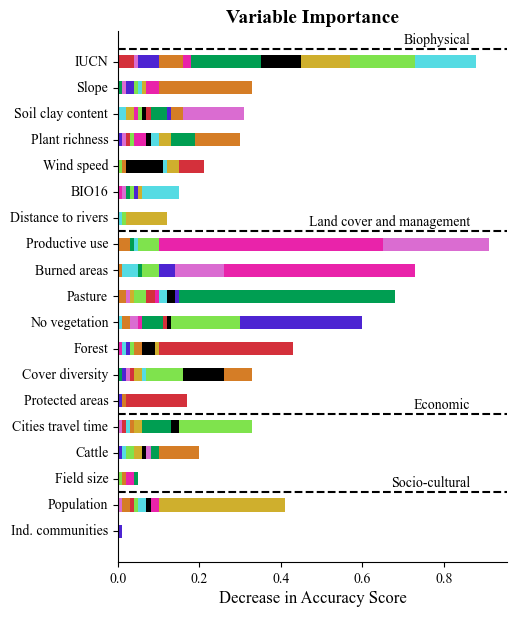

In [10]:
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Reverse the order for better plotting
desired_order_reversed = desired_order[::-1]

# Select columns to plot
columns_to_plot = ['All', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9']

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='variable', value_vars=columns_to_plot, var_name='K-means Cluster', value_name='Value')

# Convert 'variable' to categorical with the desired order
df_melted['variable'] = pd.Categorical(df_melted['variable'], categories=desired_order_reversed, ordered=True)

# Sort the DataFrame by variable and Value (higher values in the back)
df_melted = df_melted.sort_values(by=['variable', 'Value'], ascending=[True, True])

# Define a custom color palette
custom_palette = {
    'All': '#000000',  # Black
    'K1': '#D4303B',
    'K2': '#CFAF2D',
    'K3': '#009E52',
    'K4': '#DA6CD1',
    'K5': '#E923AA',
    'K6': '#4D24D2',
    'K7': '#D57D26',
    'K8': '#55DBE3',
    'K9': '#7FE34D'
}

# Create the figure
plt.figure(figsize=(5, 6))
ax = plt.gca()

# Plot manually in a loop to ensure proper overlapping
for var in df_melted['variable'].cat.categories:
    var_data = df_melted[df_melted['variable'] == var]  # Filter data for the current variable
    var_data = var_data.sort_values(by='Value', ascending=False)  # Ensure smallest in front
    
    for index, row in var_data.iterrows():
        plt.barh(
            y=row['variable'], 
            width=row['Value'], 
            color=custom_palette[row['K-means Cluster']], 
            #alpha=0.6,  # Transparency for overlap effect
            height=0.5
        )

# Remove the legend
plt.legend([], [], frameon=False)

# Set plot title and labels
plt.title('Variable Importance', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlabel('Decrease in Accuracy Score', fontsize=12)

# Rotate y-axis labels for readability
plt.yticks(rotation=0, va='center')

# Add a horizontal line next to the X-axis (very close to y=0)
plt.axhline(y=18.5, color='black', linestyle='--', linewidth=1.5)
plt.text(max(df_melted['Value']) * 0.95, 18.7, 'Biophysical', rotation=0, horizontalalignment='right')  # Adjusted y-coordinate to move the text lower

plt.axhline(y=11.5, color='black', linestyle='--', linewidth=1.5)
plt.text(max(df_melted['Value']) * 0.95, + 11.7, 'Land cover and management', rotation=0, horizontalalignment='right')

plt.axhline(y=4.5, color='black', linestyle='--', linewidth=1.5)
plt.text(max(df_melted['Value']) * 0.95, + 4.7, 'Economic', rotation=0, horizontalalignment='right')

plt.axhline(y=1.5, color='black', linestyle='--', linewidth=1.5)
plt.text(max(df_melted['Value']) * 0.95, + 1.7,'Socio-cultural', rotation=0, horizontalalignment='right')

# Remove top, right, and bottom spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

# Adjust layout
plt.tight_layout(pad=0.1)

# Show the plot
plt.show()